In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolDrawing, DrawingOptions, MolToImage

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import numpy as np

from tqdm.notebook import tqdm

from tqdm.contrib.concurrent import process_map

import pandas as pd

In [3]:
def apply_amat(acid,acid_match,amine,amine_match,rmat):
    """
    needs the smarts of the acid and amine pre-defined. maybe an external dictionary.
    """
    # combine molecules and make a writable version
    both = Chem.CombineMols(acid,amine)
    bothW = Chem.RWMol(both)
    Chem.Kekulize(both,clearAromaticFlags=True)
#     Chem.Kekulize(bothW,clearAromaticFlags=True)
    # get the indices for the acid and amine matches. NEEDS TO BE ROBUST TOWARDS MULTIPLE VALIDITIES
    amine_atoms = both.GetSubstructMatch(group_dict[amine_match])
    acid_atoms = both.GetSubstructMatch(group_dict[acid_match])
    
    if not (amine_atoms and acid_atoms):
        print("substruct match not found")
        return
    # join the indices
    atom_list = amine_atoms + acid_atoms
#     print(atom_list)
    
    # go through the amat to find places where the change is not 0
    side_len = len(rmat)
    
    if side_len != len(atom_list):
        print("matrix length does not equal number of matched atoms")
        return
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order_change = rmat[r][c]
            if bond_order_change != 0: 
                atom1 = atom_list[amat2ind[r]]
                atom2 = atom_list[amat2ind[c]]
                # get the current bond order
                current_bond = both.GetBondBetweenAtoms(atom1,atom2)
                if current_bond: 
                    current_bond_order = current_bond.GetBondTypeAsDouble()
                                       
                else: 
                    current_bond_order = 0
                
                new_bond_order = current_bond_order + bond_order_change

                
                if new_bond_order not in [0,1,2,3]:

                    return None
               
                bothW.RemoveBond(atom1,atom2)
                
                if new_bond_order > 0:
                    bothW.AddBond(atom1,atom2, bond_dict[new_bond_order])
                        
    try:
        Chem.SanitizeMol(bothW)

    except:
#         print("illegal structure")
        return None

    # may need to become smiles if we want to multitarget, as well as have fragments included.
    return bothW


In [5]:
sp2_acid_smiles = "[17O]=[17C]([18O])[16C]1=[15C]C=C(C(C2CCCCC2)=C(C3=CC=CC=C3)N4CC(N5CCOCC5)=O)C4=C1"

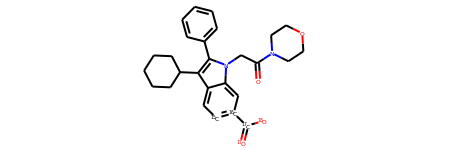

In [6]:
# sp3_acid_smiles = '[17O]=[17C]([18O])[16C]([15C]c1cnc[nH]1)N1C(=O)c2ccccc2C1=O'
enamine_acid = Chem.MolFromSmiles(sp2_acid_smiles)
Chem.Kekulize(enamine_acid,clearAromaticFlags=True)
enamine_acid

In [7]:
sp2_amine_smiles = "[15N][14C]1=[13C]C(Cl)=CC(Cl)=C1"

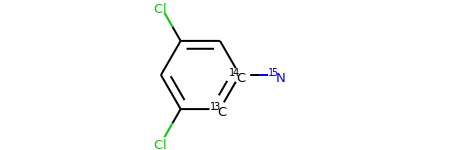

In [8]:
# sp3_amine_smiles = "[15N][14C][13C]C1CCC(N)C1"
enamine_amine = Chem.MolFromSmiles(sp2_amine_smiles)
Chem.Kekulize(enamine_amine,clearAromaticFlags=True)
enamine_amine

In [9]:
am2 = Chem.MolFromSmarts("[13C]=[14C][15N]")
ac2 = Chem.MolFromSmarts("[15C]=[16C][17C](=[17O])[18O]")
am3 = Chem.MolFromSmarts("[13C][14C][15N]")
ac3 = Chem.MolFromSmarts("[15C][16C][17C](=[17O])[18O]")


group_dict = {"ac2":ac2, "ac3":ac3,"am2":am2,"am3":am3}
# the dictionary is basically like, first entry is amine C1. second entry is amine c2. 
# this changes depending on the matrix, and how the smarts for the matcher is written. 

# number of entries in the amat
amat_indices = range(8)
# which entry each index should map to
mapping_order = [0,1,3,4,5,2,6,7]
# mapping_order = [3,4,5,0,1,2,6,7]


# amat index -> amine/acid match index
amat2ind = {k:v for k,v in zip(amat_indices, mapping_order)}

bond_dict = {1:Chem.BondType.SINGLE, 2:Chem.BondType.DOUBLE, 3:Chem.BondType.TRIPLE}


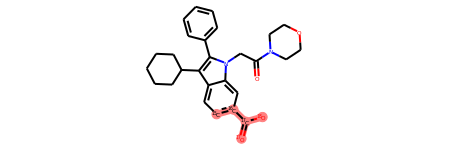

In [10]:
# enamine_acid.GetSubstructMatch(Chem.)
enamine_acid.GetSubstructMatch(ac2)
enamine_acid

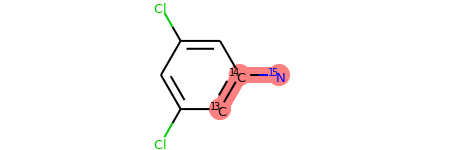

In [37]:
enamine_amine.GetSubstructMatch(am2)
enamine_amine

In [ ]:
ac2_am2 = [[0, 2, 0, 0, 0, 0, 0, 0],
           [2, 0, 0, 0, 0, 1, 0, 0],
           [0, 0, 0, 2, 0, 0, 0, 0],
           [0, 0, 2, 0, 1, 0, 0, 0],
           [0, 0, 0, 1, 0, 0, 2, 1],
           [0, 1, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 2, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 0, 0]]

In [12]:
def run_enumeration(file_tag):
    index_start = file_tag * 1000000
    file_tag = str(file_tag).zfill(2)
    pmats = np.load(f"../product_amats/pdt_amat_{file_tag}_int8.npy")
    dmats = pmats - ac2_am2
    
    out_file = open(f"./ac2drug_am2small/matrix_coupling_{file_tag}.csv","w")
    out_file.write("rmat_tag,pdt_smiles\n")
    
    for i, dmat in enumerate(dmats):
        
#         matrix_index = index_start + i
#         m = apply_amat(enamine_acid,"ac3",enamine_amine,"am3",dmat)
#         s = Chem.MolToSmiles(m,isomericSmiles=True)
#         out_file.write(s+"\n")
        try:
            matrix_index = index_start + i
            m = apply_amat(enamine_acid,"ac2",enamine_amine,"am2",dmat)
            s = Chem.MolToSmiles(m,isomericSmiles=True)
            out_file.write(f"{index_start+i},{s}\n")
        except:
            continue
    out_file.close()
    

In [13]:
run_enumeration(20)

In [25]:
# a = process_map(run_enumeration,range(56),max_workers=8,chunksize=1)

  0%|          | 0/56 [00:00<?, ?it/s]

## for processing

In [13]:
acid_parts = ["[15C]","[16C]","[17C]","[15c]","[16c]","[17c]","[17O]","[18O]","[17o]","[18o]"]
amine_parts = ["[13C]","[14C]","[13c]","[14c]","[15N]","[15n]"]

def check_smiles(s):
    coupled_smiles = []
    split_smiles = s.split(".")
    
    for ss in split_smiles:
        if any([i in ss for i in acid_parts]) and any([i in ss for i in amine_parts]):
            coupled_smiles.append(ss)
    if len(coupled_smiles) == 0:
        return "C"
    
    else:
        atom_counts = [count_atoms(s) for s in coupled_smiles]
        largest_frag_ind = np.argmax(atom_counts)
        return coupled_smiles[largest_frag_ind]
            
def count_atoms(s):
    alphab = "CONcon"
    return len([i for i in s if i in alphab])            

In [14]:

all_coupling_data = []
for file_tag in tqdm(range(56)):
    
    distance_data = pd.read_csv(f"../data_files/smiles_with_all_dists_{str(file_tag).zfill(2)}.csv")
    coupling_data = pd.read_csv(f"./ac2drug_am2small/matrix_coupling_{str(file_tag).zfill(2)}.csv")

    raw_tags = list(coupling_data.rmat_tag - file_tag*1000000)
    coupling_dists = list(distance_data.iloc[raw_tags].ac2am2)

    coupling_data["distance"] = coupling_dists


    largest_frag = []
    for s in coupling_data.pdt_smiles:
        largest_frag.append(check_smiles(s))
    coupling_data["largest_frag"] = largest_frag
    
    # remove duplicates
    coupling_data.sort_values("distance",inplace=True)
    coupling_data.drop_duplicates(subset="largest_frag",inplace=True)
    coupling_data.sort_values("rmat_tag",inplace=True)


    all_coupling_data.append(coupling_data)

  0%|          | 0/56 [00:00<?, ?it/s]

In [15]:
all_coupling_df = pd.concat(all_coupling_data)
all_coupling_df.sort_values("distance",inplace=True)

In [16]:
all_coupling_df.drop_duplicates(subset="largest_frag",inplace=True)
all_coupling_df.sort_values("rmat_tag",inplace=True)

In [17]:
all_coupling_df = all_coupling_df[all_coupling_df.largest_frag!="C"].copy()

In [18]:
all_coupling_df.head()

,rmat_tag,pdt_smiles,distance,largest_frag
20847,40932,[13C]C(Cl)=CC(Cl)=C[14C][18O][16C]C=c1c(=C[15C...,9.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][16C]C=c1c(=C[15C...
20862,40947,[13C]C(Cl)=CC(Cl)=C[14C][18O][17O][16C]C=c1c(=...,12.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][17O][16C]C=c1c(=...
20865,40950,[13C]C(Cl)=CC(Cl)=C[14C][18O][15N][17O][16C]C=...,13.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][15N][17O][16C]C=...
20870,40955,[13C]C(Cl)=CC(Cl)=C[14C][18O][17C][17O][16C]C=...,9.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][17C][17O][16C]C=...
20875,40960,[13C]C(Cl)=CC(Cl)=C[14C][18O][15N]([17C])[17O]...,14.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][15N]([17C])[17O]...


In [19]:
ring_triple_bond = Chem.MolFromSmarts("[*!R0]#[*!R0]")
cyclopropene = Chem.MolFromSmarts("[*!R0]1=[*!R0]~[*]1")
ring_allene = Chem.MolFromSmarts("[*!R0]=[*!R0]=[*!R0]")
ab_211_2 = Chem.MolFromSmarts("*1(~*2)=*~*~*2~*1")
ab_211_1 = Chem.MolFromSmarts("*1(~*2)=*~*2~*~*1")
ab_220_2 = Chem.MolFromSmarts("*12~*~*~*1=*~*2") 
ab_220_0 = Chem.MolFromSmarts("*1(~*~*2)=*2~*~*1")
ab_221_2 = Chem.MolFromSmarts("*1(~*2)~*~*~*2=*~*1")
ab_221_1 = Chem.MolFromSmarts("*12=*~*(~*~*2)~*~*1")
ab_222_2 = Chem.MolFromSmarts("*12~*~*~*(~*~*2)=*~*1")
ab_210_2 = Chem.MolFromSmarts("*12~*~*=*1~*2")
ab_210_0 = Chem.MolFromSmarts("*1(~*2)=*2~*~*1")
ab_210_1 = Chem.MolFromSmarts("*12~*~*~*1=*2")
ab_114_1 = Chem.MolFromSmarts("*1(~*2)=*~*2~*~*~*~*1")
ab_114_4 = Chem.MolFromSmarts("*1(~*2)=*~*~*~*~*2~*1")
ab_123_1 = Chem.MolFromSmarts("*12=*~*(~*~*~*2)~*~*1")
ab_123_2 = Chem.MolFromSmarts("*12=*~*~*(~*~*~*2)~*1")
ab_123_3 = Chem.MolFromSmarts("*1(~*~*2)=*~*~*~*2~*1")

myrules = [ring_triple_bond,cyclopropene,ring_allene,ab_211_2,ab_211_1,ab_220_2,ab_220_0,
           ab_221_2,ab_221_1,ab_222_2,ab_210_2,ab_210_0,ab_210_1,ab_114_1,ab_114_4,ab_123_1,ab_123_2,ab_123_3]

# bredt_passed = []
# for s in tqdm(all_coupling_df.largest_frag):
#     m = Chem.MolFromSmiles(s)

#     if not any([m.HasSubstructMatch(patt) for patt in myrules]):
#         bredt_passed.append(True)
#     else:
#         bredt_passed.append(False)

In [20]:
def check_bredt(s):
    m = Chem.MolFromSmiles(s)
    
    if not m:
        return False

    if not any([m.HasSubstructMatch(patt) for patt in myrules]):
        return True
    else:
        return False
    

In [21]:
acid_parts = ["[15C]","[16C]","[17C]","[15c]","[16c]","[17c]","[17O]","[18O]","[17o]","[18o]"]
amine_parts = ["[13C]","[14C]","[13c]","[14c]","[15N]","[15n]"]

def clean_structure(s):
    temp = s
    
    for i in acid_parts + amine_parts:
        temp = temp.replace(i,i[-2])
        
    return temp

In [23]:
bredt_check = process_map(check_bredt,list(all_coupling_df.largest_frag),max_workers=8,chunksize=10000)

  0%|          | 0/8365666 [00:00<?, ?it/s]

In [24]:
all_coupling_df["bredt"] = bredt_check

In [26]:
all_coupling_df

,rmat_tag,pdt_smiles,distance,largest_frag,bredt
20847,40932,[13C]C(Cl)=CC(Cl)=C[14C][18O][16C]C=c1c(=C[15C...,9.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][16C]C=c1c(=C[15C...,True
20862,40947,[13C]C(Cl)=CC(Cl)=C[14C][18O][17O][16C]C=c1c(=...,12.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][17O][16C]C=c1c(=...,True
20865,40950,[13C]C(Cl)=CC(Cl)=C[14C][18O][15N][17O][16C]C=...,13.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][15N][17O][16C]C=...,True
20870,40955,[13C]C(Cl)=CC(Cl)=C[14C][18O][17C][17O][16C]C=...,9.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][17C][17O][16C]C=...,True
20875,40960,[13C]C(Cl)=CC(Cl)=C[14C][18O][15N]([17C])[17O]...,14.0,[13C]C(Cl)=CC(Cl)=C[14C][18O][15N]([17C])[17O]...,True
...,...,...,...,...,...
5453,54022825,[15N]=[17C]=[16C]1C=c2c(c(C3CCCCC3)c(-c3ccccc3...,10.0,[15N]=[17C]=[16C]1C=c2c(c(C3CCCCC3)c(-c3ccccc3...,True
5456,54022828,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c1=C[16C](=[17...,11.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c1=C[16C](=[17...,True
5457,54022829,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c1=C[16C](=[17...,12.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c1=C[16C](=[17...,True
5458,54022830,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c1=C[16C](=[17...,11.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c1=C[16C](=[17...,True


In [28]:
# amide = 50175748


In [46]:
amine_ring = Chem.MolFromSmarts('[13c]1[14c]cccc1')
acid_ring = Chem.MolFromSmarts('[15c]1[16c]cccc1')

def aromatic_ring_check(s):
    m = Chem.MolFromSmiles(s)
    
    
    if not m:
        return False
    
    Chem.SanitizeMol(m)
    
    return m.HasSubstructMatch(amine_ring) and m.HasSubstructMatch(acid_ring)


# arc = []
# for s in tqdm(list(all_coupling_df.largest_frag)):
#     arc.append(aromatic_ring_check(s))

In [47]:
ring_check = process_map(aromatic_ring_check,list(all_coupling_df.largest_frag),max_workers=8,chunksize=10000)

print(sum(ring_check)/len(ring_check))

all_coupling_df["aromatic"] = ring_check

  0%|          | 0/8365666 [00:00<?, ?it/s]

0.0016250947623297415


In [51]:
s_cleaned = []
for s in tqdm(list(all_coupling_df['largest_frag'])):
    s_cleaned.append(clean_structure(s))

  0%|          | 0/8365666 [00:00<?, ?it/s]

In [53]:
all_coupling_df["largest_cleaned"] = s_cleaned

In [54]:
all_coupling_df.sort_values("distance",inplace=True)
all_coupling_df.drop_duplicates(subset="largest_cleaned",inplace=True)

In [57]:
all_coupling_df = all_coupling_df[all_coupling_df.bredt].copy()

In [59]:
all_coupling_df.reset_index(drop=True,inplace=True)

In [60]:
all_coupling_df.head()

,rmat_tag,pdt_smiles,distance,largest_frag,bredt,aromatic,largest_cleaned
0,50231461,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c]([15N][1...,1.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c]([15N][1...,True,True,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2cc(Nc3cc(Cl)cc...
1,53844353,[15N][14c]1cc(Cl)cc(Cl)[13c]1-[15c]1cc2c(C3CCC...,1.0,[15N][14c]1cc(Cl)cc(Cl)[13c]1-[15c]1cc2c(C3CCC...,True,True,Nc1cc(Cl)cc(Cl)c1-c1cc2c(C3CCCCC3)c(-c3ccccc3)...
2,50626702,[15N][14c]1cc(Cl)cc(Cl)[13c]1[18O][17C](=[17O]...,1.0,[15N][14c]1cc(Cl)cc(Cl)[13c]1[18O][17C](=[17O]...,True,True,Nc1cc(Cl)cc(Cl)c1OC(=O)c1cc2c(cc1)c(C1CCCCC1)c...
3,50230203,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c][16c]([1...,1.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c][16c]([1...,True,True,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2ccc(C(=O)ONc3c...
4,53844354,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c]3[16c](c...,2.0,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2c[15c]3[16c](c...,True,True,O=C(Cn1c(-c2ccccc2)c(C2CCCCC2)c2cc3c(cc21)C(=O...


In [61]:
all_coupling_df[["rmat_tag","distance","largest_frag","largest_cleaned"]].to_csv("coupled_ac2drug_am2small.csv",index=False)

In [62]:
all_coupling_df = all_coupling_df[all_coupling_df.aromatic].copy()
all_coupling_df.reset_index(drop=True,inplace=True)

In [63]:
all_coupling_df[["rmat_tag","distance","largest_frag","largest_cleaned"]].to_csv("coupled_aromatic_ac2drug_am2small.csv",index=False)